In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from copy import deepcopy

# convert series to supervised learning
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [47]:
# getting data
features = ['SWTP Total Influent Flow', 'SWTP Plant 2 Influent Flow', 'Wilsons Gauge Height (ft)', 'James Gauge Height (ft)', 
            'SWTP Plant 1 Influent Flow', 'Fire 168 Hour Rainfall Aggregate', 'AT&T 168 Hour Rainfall Aggregate', 
            'Field 168 Hour Rainfall Aggregate', 'Springfield Plateau Aquifer Depth to Water Level (ft)', 
            'Ozark Aquifer Depth to Water Level (ft)', 'Month', 'Hour', 'Week', 'Year']

dataset = pd.read_csv("Imputed Data.csv", usecols=features)
values = dataset.values

# linear transformation of each feature from [min, max] to [0, 1]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# reframing data into a forecasting problem
numBackward = 60
numForward = 1
reframed = series_to_supervised(scaled, numBackward, numForward)            #(x, 73) for 72 values in the future, x is a hyperparameter

# dropping columns we do not need
numCols = len(dataset.columns)
undesiredCols = [x for x in range(numCols * numBackward + 1, numCols * (numBackward + numForward))]
reframed.drop(reframed.columns[undesiredCols], axis = 1, inplace =True)     #everthing after var1(t) must be dropped

In [48]:
# splitting into training and testing sets
values = reframed.values
n_train_hours = 4 * 365 * 24                                # first four years, roughly
train = deepcopy(values[:n_train_hours:, :])
test = deepcopy(values[n_train_hours:, :])

# separating into X and Y datasets
train_X, train_y = train[:, :-1], train[:, -1]              # [all rows, up to last col, i.e. var1(t)] and [all rows, just last col, i.e. var1(t)]
test_X, test_y = test[:, :-1], test[:, -1]

# changing input to be 3D for the model
train_X = train_X.reshape((train_X.shape[0], numBackward, len(features)))   # rows, time lags, features
test_X_copy = deepcopy(test_X)
test_X = test_X.reshape((test_X.shape[0], numBackward, len(features)))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 60, 14) (35040,) (9132, 60, 14) (9132,)


In [39]:
# creating model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss ='mae', optimizer ='adam')

# path = "C:\\Users\\natha\\Desktop\\Undergrad\\Spring2022\\MTH 596 PIC Math\\Project - Group 2\\Project\\Forecasting\\keras_tuner_attempt1\\model"
# model = keras.models.load_model(path)   # must pay attention to numBackward and numForward used to train the model

# fitting model to data
history = model.fit(train_X, train_y, epochs=12, batch_size=64, validation_data=(test_X,test_y), verbose=2, shuffle=False)

Epoch 1/12
548/548 - 12s - loss: 0.0415 - val_loss: 0.0443 - 12s/epoch - 22ms/step
Epoch 2/12
548/548 - 9s - loss: 0.0229 - val_loss: 0.0318 - 9s/epoch - 17ms/step
Epoch 3/12
548/548 - 9s - loss: 0.0191 - val_loss: 0.0295 - 9s/epoch - 17ms/step
Epoch 4/12
548/548 - 9s - loss: 0.0165 - val_loss: 0.0259 - 9s/epoch - 17ms/step
Epoch 5/12
548/548 - 17s - loss: 0.0152 - val_loss: 0.0252 - 17s/epoch - 30ms/step
Epoch 6/12
548/548 - 14s - loss: 0.0141 - val_loss: 0.0237 - 14s/epoch - 26ms/step
Epoch 7/12
548/548 - 10s - loss: 0.0132 - val_loss: 0.0253 - 10s/epoch - 17ms/step
Epoch 8/12
548/548 - 9s - loss: 0.0126 - val_loss: 0.0272 - 9s/epoch - 17ms/step
Epoch 9/12
548/548 - 10s - loss: 0.0133 - val_loss: 0.0288 - 10s/epoch - 18ms/step
Epoch 10/12
548/548 - 9s - loss: 0.0120 - val_loss: 0.0291 - 9s/epoch - 17ms/step
Epoch 11/12
548/548 - 9s - loss: 0.0120 - val_loss: 0.0297 - 9s/epoch - 17ms/step
Epoch 12/12
548/548 - 9s - loss: 0.0119 - val_loss: 0.0281 - 9s/epoch - 17ms/step


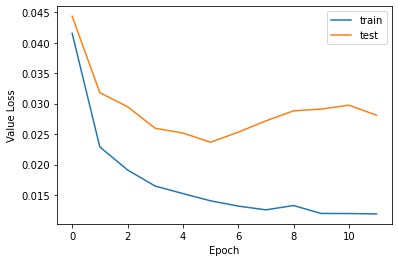

In [40]:
# plot history -- the "%matplotlib qt" command makes the graph pop out into a new window, inline shows below the cell
%matplotlib inline
# %matplotlib qt
plt.plot(history.history['loss'], label= 'train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Value Loss")
plt.legend()
plt.show()
# print(history.history.keys())

In [45]:
def normalize(arr, maximum, minimum):
    return (arr - minimum) / (maximum - minimum)

def invNormalize(arr, minimum, maximum):
    return (maximum - minimum) * arr + minimum

# getting dates and original influent flow data
df = pd.read_csv("Imputed Data.csv", usecols=["DateTime", "SWTP Total Influent Flow"])
arr = np.array(df["SWTP Total Influent Flow"])
maximum = np.max(arr)
minimum = np.min(arr)

# predicting
predictions = invNormalize(model.predict(test_X), maximum, minimum)
trueValues = invNormalize(test_y, maximum, minimum)
print("MSE:", mean_squared_error(predictions, trueValues))
print("RMSE:", np.sqrt(mean_squared_error(predictions, trueValues)))

MSE: 18.296287779498584
RMSE: 4.277416016650541


In [42]:
# make a prediction
yhat = model.predict(test_X)
# test_X_transformed = test_X.reshape((test_X.shape[0], n_train_hours * len(features)))
test_X_transformed = test_X_copy
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_transformed[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_transformed[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (9173,8) (14,) (9173,8) 